In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import DBSCAN
%matplotlib widget

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
# diffusion="0.05percent"
diffusion="nodiff"
# file_id = "1"
file_id = "2638"

if (pressure == 1):
    det_size = 6.182*1e3
elif (pressure == 5):
    det_size = 3.615*1e3
elif (pressure == 10):
    det_size = 2.870*1e3
elif (pressure == 15):
    det_size = 2.507*1e3
elif (pressure == 25):
    det_size = 2.114*1e3


# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")


hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_Efilt_smear_{file_id}.h5", "MC/hits")

if (diffusion == "nodiff"):
    hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_Efilt_smear_{file_id}.h5", "MC/hits")
else:
    hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_Efilt_{diffusion}_smear_{file_id}.h5", "MC/hits")


# hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_1bar_nexus_2954.h5", "MC/hits")
# hits = pd.read_hdf("../data/ATPC_Tl/ATPC_Tl_1bar_smear_2954.h5", "MC/hits")

display(hits)

event_list = hits.event_id.unique()

eid=event_list[1]
# eid = 321979

data = hits[hits.event_id ==eid]
# data = CutandRedistibuteEnergy(data, 0.0004)

data_true = hits_true[hits_true.event_id == eid]
# data_true["z"] = data_true["z"]-det_size/2.0

# print(hits.event_id.unique())

,event_id,x,y,z,energy
0,321959,-410.572235,-1181.202393,2049.441895,0.009226
1,321959,-408.957703,-1177.483521,2049.495605,0.000248
2,321959,-412.010773,-1186.013062,2049.520752,0.013293
3,321959,-408.062012,-1175.414185,2049.576904,0.001538
4,321959,-405.763214,-1170.482544,2049.633789,0.000843
...,...,...,...,...,...
66952,322032,1472.051880,-1545.291016,526.739502,0.000322
66953,322032,1474.797729,-1545.046875,528.489685,0.001265
66954,322032,1482.435181,-1549.546753,528.700806,0.001885
66955,322032,1481.030518,-1549.226196,529.348267,0.000769


In [3]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist, voxel_size, det_half_length = InitializeParams(pressure, diffusion)

print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Hit grouping factor is: ",     group_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)
print("The voxel size is: ",           voxel_size)

# group_sf = 10

mean_sigma = group_sf*Diff_smear*np.sqrt(0.1*data.z.mean())

# The expected diffusion is less than vox size so replace
if (mean_sigma < 1.5*voxel_size):
    mean_sigma = 1.5*voxel_size

print("mean_sigma:", mean_sigma)

Diffussion smear is:  0.1 mm/sqrt(cm)
Energy threshold is:  0.0 keV
diffision scale factor is:  7
Radius scale factor is:  10
Hit grouping factor is:  10
Tortuosity distance scale is: 70.0
The voxel size is:  5
mean_sigma: 17.344068127713


In [4]:
reco_DE_event = data.copy()

print(len(reco_DE_event))

reco_DE_event = CutandRedistibuteEnergy(reco_DE_event, energy_threshold)

df_merged = GroupHits(reco_DE_event, mean_sigma)

944


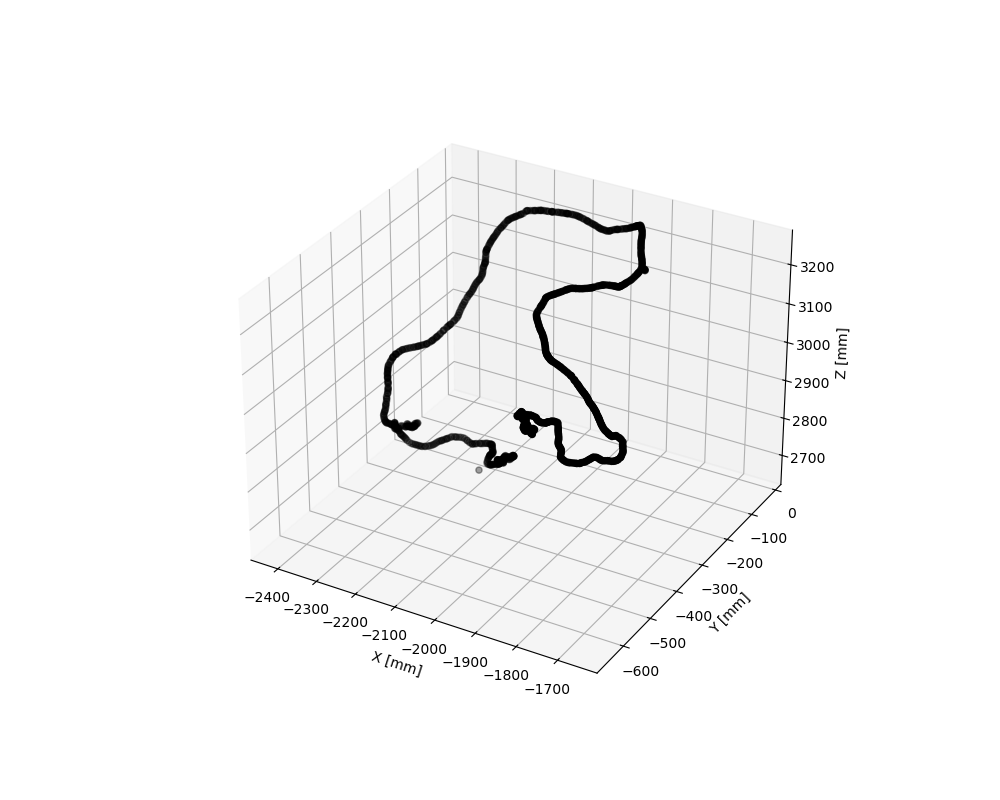

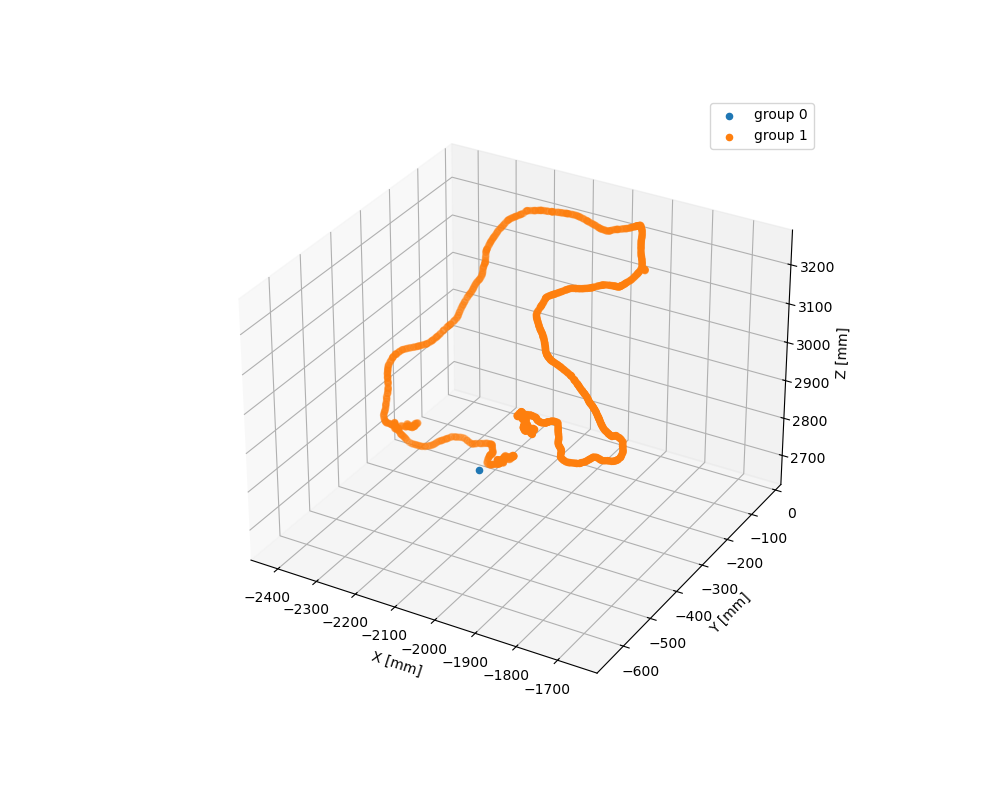

In [5]:

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(data_true['x'], data_true['y'], data_true['z'],c="k")
# ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

ax1.set_xlabel("X [mm]")
ax1.set_ylabel("Y [mm]")
ax1.set_zlabel("Z [mm]")


fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
for gid in sorted(df_merged["group_id"].unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    ax1.scatter(temp_df['x'], temp_df['y'], temp_df['z'],label = f"group {gid}")
    # ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

    ax1.set_xlabel("X [mm]")
    ax1.set_ylabel("Y [mm]")
    ax1.set_zlabel("Z [mm]")
    ax1.legend()
# plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/GroupedHits.pdf")

In [2]:
for eid in hits.event_id.unique():
    data = hits[hits.event_id ==eid]

    Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist = InitializeParams(pressure, diffusion)

    # group_sf = 30
    # energy_threshold=0.0004

    reco_DE_event = CutandRedistibuteEnergy(data, energy_threshold)

    mean_sigma = group_sf*Diff_smear*np.sqrt(0.1*reco_DE_event.z.mean())
    # print(group_sf, Diff_smear, mean_sigma)

    df_merged = GroupHits(reco_DE_event, mean_sigma)

    # # If we have too many groups then bump up the voxel size since the track was broken too much
    # if (len(df_merged.group_id.unique()) > 7):
    #     print("Running grouping again new mean sigma is:", mean_sigma*15)
    #     df_merged = GroupHits(reco_DE_event, mean_sigma*15)

    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(111, projection='3d')
    for gid in sorted(df_merged["group_id"].unique()):
        temp_df = df_merged[df_merged.group_id == gid]
        ax1.scatter(temp_df['x'], temp_df['y'], temp_df['z'],label = f"group {gid}")
        # ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

        ax1.set_xlabel("X [mm]")
        ax1.set_ylabel("Y [mm]")
        ax1.set_zlabel("Z [mm]")
        ax1.legend()

    plt.savefig(f"plots/grouping/{pressure}bar/{diffusion}/{eid}.pdf")
    plt.close()

Running grouping again new mean sigma is: 109.59659130893664
Running grouping again new mean sigma is: 187.1777650979686
Running grouping again new mean sigma is: 203.8573042009391
Running grouping again new mean sigma is: 186.56301306265823
Running grouping again new mean sigma is: 134.0380753468961
Running grouping again new mean sigma is: 127.55463665916638
